In [78]:
import os
import sys
import xml.etree.ElementTree as ET

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve

# model's selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# models
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# work with images
from PIL import Image

# other
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

In [53]:
text_dir = './Text'
nontext_dir = './Nontext'

функция для парсинга данных в формате `xml`

In [54]:
def parse_data(directoty):
    x = []
    for filename in os.listdir(directoty):
        if filename[-3:].lower() != 'xml':
            continue
        tree = ET.parse(directoty + '/' + filename)
        root = tree.getroot()
        image = list(root)[-1]
        for word_fragment in image:
            image_info = {
                'BlackCount' : None,
                'WhiteHolesCount' : None,
                'HorzStrokesCount' : None,
                'VertStrokesCount' : None,
                'MaxHorzStrokeLength' : None,
                'Left' : None,
                'Top' : None,
                'Right' : None,
                'Bottom' : None
            }
            for attr_key in word_fragment.attrib:
                if attr_key not in image_info:
                    continue
                image_info[attr_key] = int(word_fragment.attrib[attr_key])
            rect = list(word_fragment)[0].attrib
            for attr_key in rect:
                image_info[attr_key] = int(rect[attr_key])
            info = []
            for key in image_info:
                info.append(image_info[key])
            x.append(info)
    
    return np.array(x)

Вспомогательные функции для отрисовки графиков

In [108]:
def draw_roc_curve(y_true, y_pred, title, show_auc=True, figsize=(18,9)):
    plt.figure(figsize=figsize)
    plt.grid()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    if show_auc:
        plt.plot(fpr, tpr, linewidth=3., label="roc-auc score: {:0.5f}".format(roc_auc_score(y_true, y_pred)))
        plt.legend(fontsize=24)
    else:
        plt.plot(fpr, tpr, linewidth=3.)
    plt.plot([0, 1], [0, 1], 'ko--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title(title)
    plt.show()

In [114]:
def draw_pr_curve(y_true, y_pred, title, show_auc=True, figsize=(18,9)):
    plt.figure(figsize=figsize)
    plt.grid()
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    if show_auc:
        plt.plot(precision, recall,
                 linewidth=3., 
                 label="pr-auc score: {:0.5f}".format(
                     average_precision_score(y_test, y_pred)))
        plt.legend(fontsize=24)
    else:
        plt.plot(precision, recall,
                 linewidth=3.)
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title(title)
    plt.show()

In [57]:
x_text = parse_data(text_dir)
x_nontext = parse_data(nontext_dir)

In [58]:
np.save('save_text', x_text)
np.save('save_nontext', x_nontext)

объединим данные, создадим метки, разделим на `test` и `train`

In [59]:
x = np.array([*x_text] + [*x_nontext], np.float)
y = np.array([1]*x_text.shape[0] + [0]*x_nontext.shape[0])

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Проверим Knn

In [61]:
knn = KNeighborsClassifier()

param = {
    'n_neighbors': [1,3,5,7],
    'weights': ['uniform', 'distance'],
    'p': [2,3,5]
}

gscv = GridSearchCV(knn, param, cv=3, verbose=1, n_jobs=-1)
gscv.fit(x_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   32.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1, 3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [62]:
best_knn = gscv.best_estimator_
print("Accuracy: {}".format(accuracy_score(y_test, best_knn.predict(x_test))))

Accuracy: 0.9350151127644734


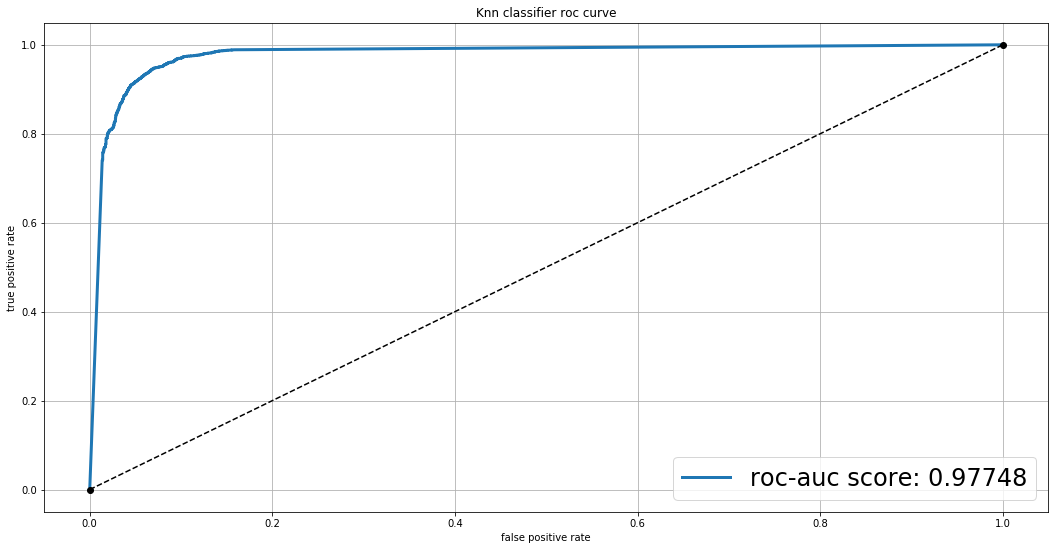

In [115]:
draw_roc_curve(y_test, best_knn.predict_proba(x_test)[:, 1], "Knn classifier roc curve")

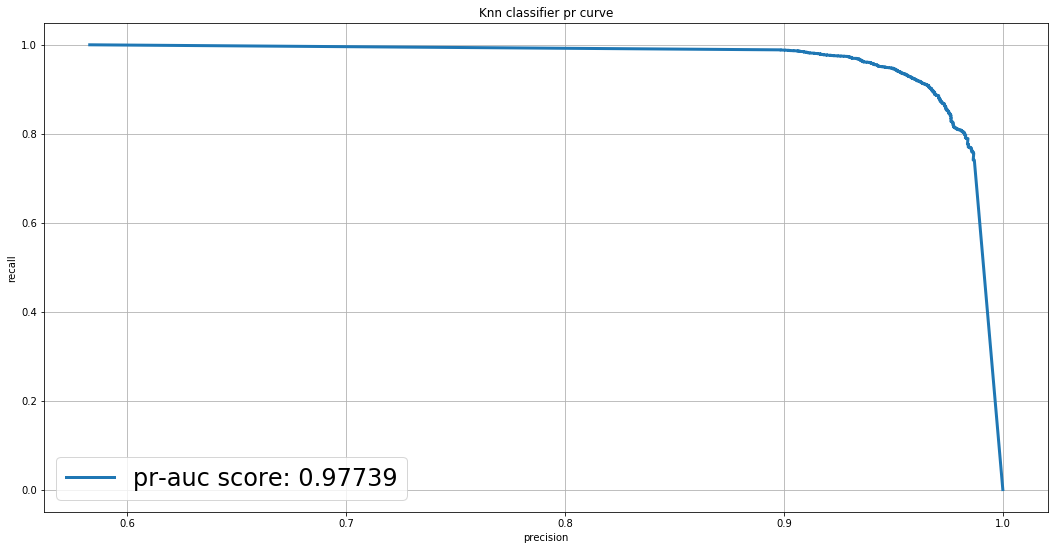

In [116]:
draw_pr_curve(y_test, best_knn.predict_proba(x_test)[:, 1], "Knn classifier pr curve")

Попробуем другую модель - случайный лес

In [65]:
param = {
    'criterion': ['gini', 'entropy'],
    'n_estimators' : [10, 20, 50, 100], 
    'max_depth' : [None, 5, 10]
}

gscv = GridSearchCV(RandomForestClassifier(), param, cv=3, verbose=1, n_jobs=-1)
gscv.fit(x_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   29.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [10, 20, 50, 100], 'max_depth': [None, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [66]:
best_rf_clf = gscv.best_estimator_

In [67]:
print("Acuracy: {}".format(accuracy_score(y_test, best_rf_clf.predict(x_test))))

Acuracy: 0.9753545687049523


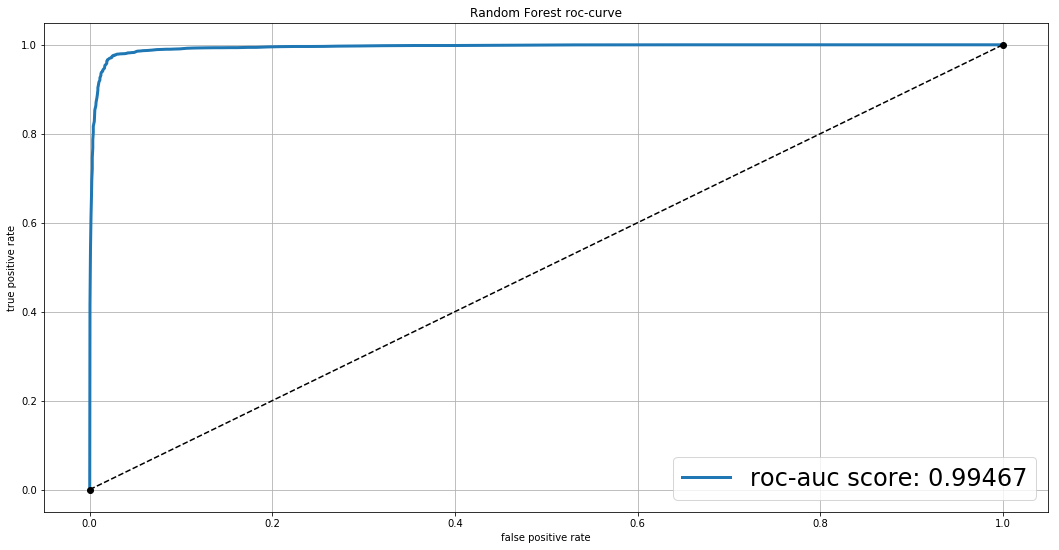

In [117]:
draw_roc_curve(y_test, best_rf_clf.predict_proba(x_test)[:,1], "Random Forest roc-curve")

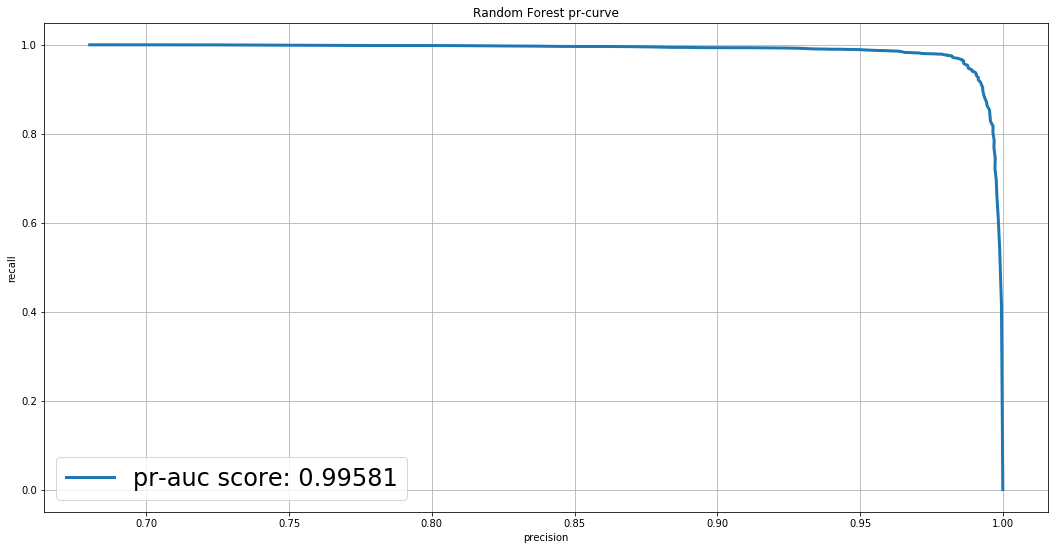

In [118]:
draw_pr_curve(y_test, best_rf_clf.predict_proba(x_test)[:,1], "Random Forest pr-curve")

Последняя модель, на работу которой посмотрим - градиентный бустинг

In [70]:
xgb = XGBClassifier()
param = {
    'max_depth' : [3, 5, 7, 10],
    'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.5, 1.],
    'n_estimators' : [50, 100, 150, 350, 500, 700]
}
gscv = GridSearchCV(xgb, param, cv=3, n_jobs=-1, verbose=5)
gscv.fit(x_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 21.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 10], 'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5, 1.0], 'n_estimators': [50, 100, 150, 350, 500, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [71]:
best_xgb_clf = gscv.best_estimator_

In [72]:
print("Acuracy: {}".format(accuracy_score(y_test, best_xgb_clf.predict(x_test))))

Acuracy: 0.9801209021157871


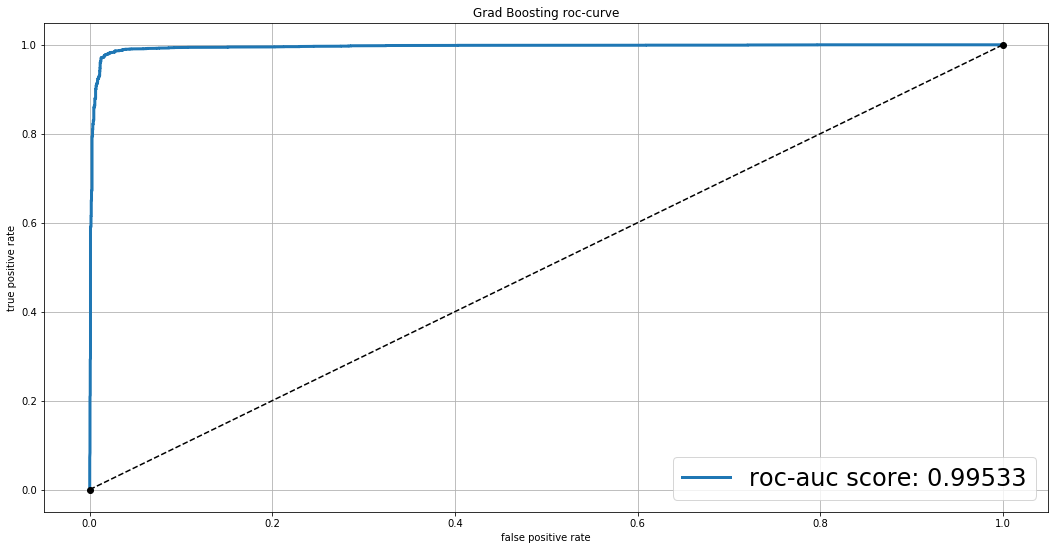

In [119]:
draw_roc_curve(y_test, best_xgb_clf.predict_proba(x_test)[:,1], "Grad Boosting roc-curve")

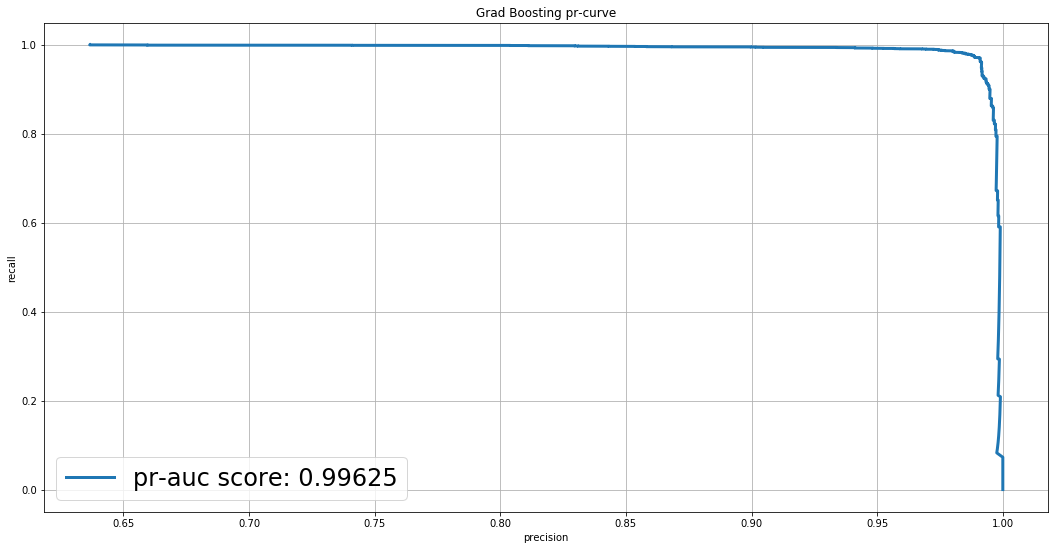

In [120]:
draw_pr_curve(y_test, best_xgb_clf.predict_proba(x_test)[:,1], "Grad Boosting pr-curve")

Похоже, `Xgb` победитель - еще сильнее улучшать показатели, кажется, не имеет большого смысла. Посмотрим на параметры получившейся модели

In [168]:
gscv.best_params_

{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 500}

Лучше всего себя показал `XGBClassifier`. Его и будем использовать.
Посмотрим, как применять нашу модель для определения текста/не текста

Определим вспомогательную функцию. Аналогично функции, с помощью которой мы извлекали датасет, эта функция формирует датасет на основании одной картинки.

In [98]:
def parse_img(path):
    x = []
    tree = ET.parse(path)
    root = tree.getroot()
    image = list(root)[-1]
    for word_fragment in image:
        image_info = {
            'BlackCount' : None,
            'WhiteHolesCount' : None,
            'HorzStrokesCount' : None,
            'VertStrokesCount' : None,
            'MaxHorzStrokeLength' : None,
            'Left' : None,
            'Top' : None,
            'Right' : None,
            'Bottom' : None
        }
        for attr_key in word_fragment.attrib:
            if attr_key not in image_info:
                continue
            image_info[attr_key] = int(word_fragment.attrib[attr_key])
        rect = list(word_fragment)[0].attrib
        for attr_key in rect:
            image_info[attr_key] = int(rect[attr_key])
        info = []
        for key in image_info:
            info.append(image_info[key])
        x.append(info)

    return np.array(x)

In [105]:
def classify_image(xml_path, img_path=None,
                   actual_class=None, 
                   show_picture=True,
                   more_important_to_classify_text=True,
                   clf=best_xgb_clf):
    '''
    this function classifies the image. Predictions are made on xml data
    
    @param xml_path: path to xml file of the picture
    @param img_path: path to original image (if you want to show if)
    @param show_picture: whether to show picture or not 
                        (make sure, that if show_picture==True, img_path is not None)
    @param actual_class: Actual class of the image. It takes a string and prints it
    @param more_important_to_classify_text: if True, it predicts picture 
                                            to be text if not sure
    @param clf: classifier, which makes predictions (default=xgb)
    '''
    if show_picture:
        assert (img_path is not None), "There must be path to the picture"
        imshow(Image.open(img_path))
    
    x = parse_img(xml_path)
    predictions = clf.predict(x)
    if actual_class is not None:
        print("Actual class: {}".format(actual_class))
    
    ones = (predictions == 1).sum()
    zeroes = (predictions == 0).sum()
    condition = None
    if more_important_to_classify_text:
        condition = (ones >= zeroes)
    else:
        condition = (ones > zeroes)
    
    print("Predicted class: {}".format(("Text" if condition else "NonText")))
    

Actual class: Text
Predicted class: Text


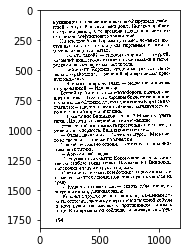

In [106]:
img_path_text = './Text/0001.tif'
xml_path_text = './Text/0001.xml'
classify_image(xml_path_text, img_path_text, actual_class="Text")

Actual class: NonText
Predicted class: NonText


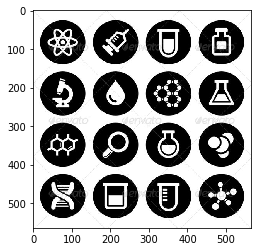

In [107]:
img_path_text = './Nontext/1.jpg'
xml_path_text = './Nontext/1.xml'
classify_image(xml_path_text, img_path_text, actual_class="NonText")

Выберем картинку и посмотрим, когда наш классификатор ошибается

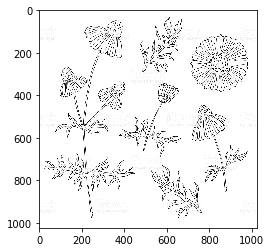

In [123]:
choosen_xml = './Nontext/2.xml'
choosen_img = './Nontext/2.jpg'

imshow(Image.open(choosen_img))

In [124]:
x = parse_img(choosen_xml)
predictions = best_xgb_clf.predict(x)

ones = (predictions == 1).sum()
zeroes = (predictions == 0).sum()
print("Predicted as text: {} blocks".format(ones))
print("Predicted as non-text: {} blocks".format(zeroes))

Predicted as text: 0 blocks
Predicted as non-text: 488 blocks


На этом примере даже не получилось проанализировать ошибки)

Посмотрим на другой

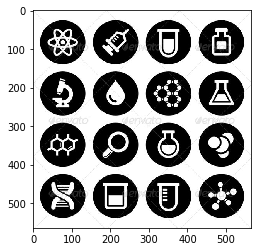

In [159]:
choosen_xml = './Nontext/1.xml'
choosen_img = './Nontext/1.jpg'

imshow(Image.open(choosen_img))

In [160]:
x = parse_img(choosen_xml)
predictions = best_xgb_clf.predict(x)

ones = (predictions == 1).sum()
zeroes = (predictions == 0).sum()
print("Predicted as text: {} blocks".format(ones))
print("Predicted as non-text: {} blocks".format(zeroes))

Predicted as text: 3 blocks
Predicted as non-text: 128 blocks


In [161]:
false_predicted = [i for i in range(len(predictions)) if predictions[i] == 1]

In [162]:
im = Image.open(choosen_img)
cropped_ims = []

for index in false_predicted:
    crop_rectangle = tuple(x[index][-4:])
    cropped_ims.append(im.crop(crop_rectangle))

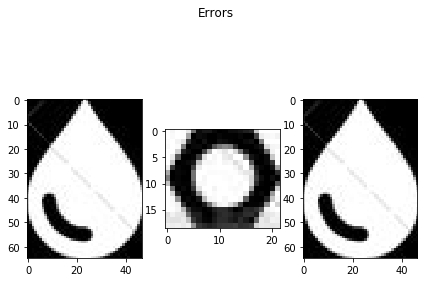

In [169]:
fig = plt.figure(figsize=(7, 5))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

ax0.imshow(cropped_ims[0])
ax1.imshow(cropped_ims[1])
ax2.imshow(cropped_ims[2])

plt.suptitle("Errors")
plt.show()

Еще посмотрим на ошибки картинки, на которой изображен текст

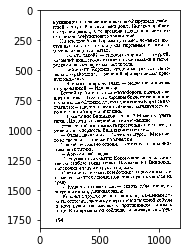

In [172]:
choosen_xml = './Text/0001.xml'
choosen_img = './Text/0001.tif'

imshow(Image.open(choosen_img))

In [173]:
x = parse_img(choosen_xml)
predictions = best_xgb_clf.predict(x)

ones = (predictions == 1).sum()
zeroes = (predictions == 0).sum()
print("Predicted as text: {} blocks".format(ones))
print("Predicted as non-text: {} blocks".format(zeroes))

Predicted as text: 1210 blocks
Predicted as non-text: 2 blocks


In [174]:
false_predicted = [i for i in range(len(predictions)) if predictions[i] == 1]

In [175]:
im = Image.open(choosen_img)
cropped_ims = []

for index in false_predicted:
    crop_rectangle = tuple(x[index][-4:])
    cropped_ims.append(im.crop(crop_rectangle))

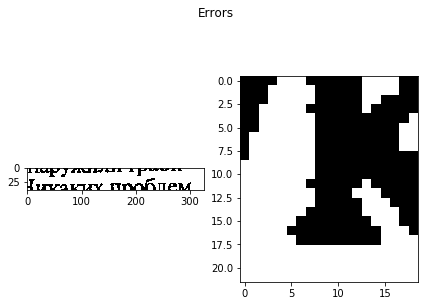

In [176]:
fig = plt.figure(figsize=(7, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

ax0.imshow(cropped_ims[0])
ax1.imshow(cropped_ims[1])

plt.suptitle("Errors")
plt.show()

В тексте ошибка на первом прямоугольнике скорее всего из-за того, что слишком много белого

Если не знать, что на втором прямоугольнике изображена буква, то даже человеку будет немного затруднительно понять, что здесь изображено)

**Вывод** 

Составил датасет, на основе xml разметки картинки, затем, получившийся датасет разбил на обучение/тест в пропорции 80/20.

Посмотрел на различные sklern'овские классификаторы. Все из них довольно неплохо справились с задачей классификации, но лучше всех себя показал `XGBClassifier` ( > .98 `accuracy` ~ 1. `pr-auc` ~ 1. `roc-auc`)

Также написал вспомогательную функцию, которая на основе xml разметки классифицирует исходную картинку.
на данном датасете классификатор справляется почти идеально, что обусловлено высокими показателями метрик

И посмотрел на ошибки, которые допускает классификатор. Их не так уж и много